In [1]:
!pip install idx2numpy


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# path to kaggle data
train_images_path = "train-images.idx3-ubyte"
train_labels_path = "train-labels.idx1-ubyte"
test_images_path = "t10k-images.idx3-ubyte"
test_labels_path = "t10k-labels.idx1-ubyte"

# convert idx file -> numpy array
X_train = idx2numpy.convert_from_file(train_images_path)
y_train = idx2numpy.convert_from_file(train_labels_path)
X_test = idx2numpy.convert_from_file(test_images_path)
y_test = idx2numpy.convert_from_file(test_labels_path)


print("training image data size:", X_train.shape)  
print("training label data size:", y_train.shape)   
print("test image data size:", X_test.shape)  
print("test label data size:", y_test.shape)    


training image data size: (60000, 28, 28)
training label data size: (60000,)
test image data size: (10000, 28, 28)
test label data size: (10000,)


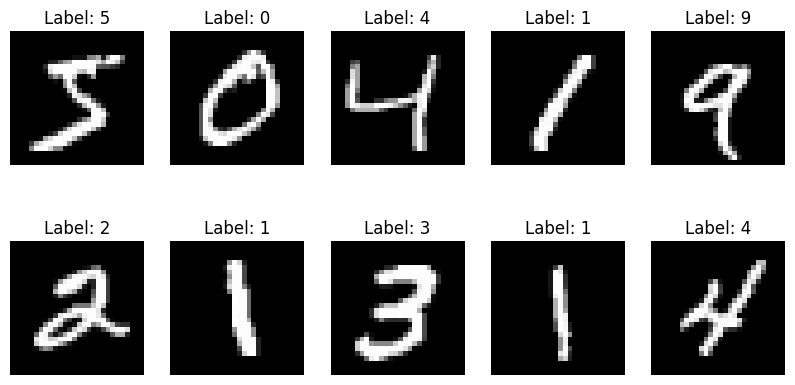

In [4]:
# outputting random image 
plt.figure(figsize=(10, 5))

for i in range(10):  # output 10 sample 
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i], cmap="gray")  # gray picture
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")

plt.show()


In [5]:
# flattening image data -> 2d vector 
X_train = X_train.reshape(60000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("flattened trainig data size: ", X_train.shape)
print("flattened test data size: ", X_test.shape)

flattened trainig data size:  (60000, 784)
flattened test data size:  (10000, 784)


M=10000: Random Accuracy=0.9670 ± 0.0135
M=10000: Centroid Accuracy=0.8450 ± 0.0000
M=5000: Random Accuracy=0.9300 ± 0.0190
M=5000: Centroid Accuracy=0.8300 ± 0.0000
M=1000: Random Accuracy=0.8790 ± 0.0145
M=1000: Centroid Accuracy=0.7700 ± 0.0000


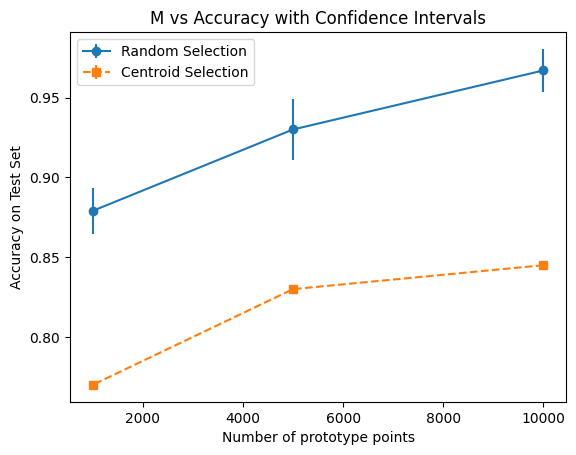

In [6]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import math

def compute_distance(a, b):
    return np.linalg.norm(a - b)

# Prototype Selection Strategy
# - Random selection: Selects M samples randomly from the training set.
# - Centroid-based selection: Computes the centroid of each class and selects the closest sample.
# - The goal is to evaluate whether choosing representative prototypes improves 1-NN classification accuracy.

def random_prototype_selection(X_train, y_train, M):
    """
    Randomly selects M samples from the training set.
    """
    indices = np.random.choice(len(X_train), M, replace=False)
    return X_train[indices], y_train[indices]

def prototype_selection(X_train, y_train, M):
    """
    Selects prototypes based on class centroids.
    - Instead of selecting only one sample per class, it selects M samples in a balanced way.
    """
    label_image_dict = defaultdict(list)
    
    for i in range(len(X_train)):
        label = y_train[i]
        label_image_dict[label].append(X_train[i])
    
    prototypes = []
    prototype_labels = []
    
    num_classes = len(label_image_dict)
    samples_per_class = max(1, M // num_classes)  # Adjust to distribute M samples across all classes
    
    for label in label_image_dict:
        class_samples = np.array(label_image_dict[label])
        centroid = np.mean(class_samples, axis=0)
        
        # Find the closest samples to the centroid
        distances = np.linalg.norm(class_samples - centroid, axis=1)
        closest_indices = np.argpartition(distances, samples_per_class)[:samples_per_class]
        
        for idx in closest_indices:
            prototypes.append(class_samples[idx])
            prototype_labels.append(label)
    
    return np.array(prototypes), np.array(prototype_labels)

def compute_confidence_interval(results):
    mean = np.mean(results)
    std_dev = np.std(results)
    ci = 1.96 * (std_dev / math.sqrt(len(results)))  # 95% confidence interval
    return mean, ci

def one_nn_predict(X_train, y_train, X_test):
    """
    Implements 1-Nearest Neighbor classification manually with optimized memory usage.
    """
    y_pred = []
    for test_sample in X_test:
        distances = np.linalg.norm(X_train - test_sample, axis=1)  # Compute distances one by one
        nearest_index = np.argmin(distances)
        y_pred.append(y_train[nearest_index])
    return np.array(y_pred)

def evaluate_prototypes(X_train, y_train, X_test, y_test, M, method="random"):
    if method == "random":
        X_proto, y_proto = random_prototype_selection(X_train, y_train, M)
    elif method == "centroid":
        X_proto, y_proto = prototype_selection(X_train, y_train, M)
    else:
        raise ValueError("Unknown method")
    
    y_pred = one_nn_predict(X_proto, y_proto, X_test)
    accuracy = np.mean(y_pred == y_test)
    return accuracy

def experiment(X_train, y_train, X_test, y_test, M, trials=5, method="random"):
    results = [evaluate_prototypes(X_train, y_train, X_test, y_test, M, method) for _ in range(trials)]
    return compute_confidence_interval(results)

# Reduce memory usage by using float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Reduce test dataset size for initial runs
X_test_sample = X_test[:200]
y_test_sample = y_test[:200]

# Experiment Setup
M_values = [10000, 5000, 1000]
accuracies_random = []
accuracies_centroid = []
confidence_intervals_random = []
confidence_intervals_centroid = []

for M in M_values:
    mean_acc_random, ci_random = experiment(X_train, y_train, X_test_sample, y_test_sample, M, method="random")
    mean_acc_centroid, ci_centroid = experiment(X_train, y_train, X_test_sample, y_test_sample, M, method="centroid")
    
    accuracies_random.append(mean_acc_random)
    accuracies_centroid.append(mean_acc_centroid)
    confidence_intervals_random.append(ci_random)
    confidence_intervals_centroid.append(ci_centroid)
    
    print(f"M={M}: Random Accuracy={mean_acc_random:.4f} ± {ci_random:.4f}")
    print(f"M={M}: Centroid Accuracy={mean_acc_centroid:.4f} ± {ci_centroid:.4f}")

# Accuracy Comparison Plot
plt.errorbar(M_values, accuracies_random, yerr=confidence_intervals_random, fmt='o-', label='Random Selection')
plt.errorbar(M_values, accuracies_centroid, yerr=confidence_intervals_centroid, fmt='s--', label='Centroid Selection')
plt.xlabel('Number of prototype points')
plt.ylabel('Accuracy on Test Set')
plt.title('M vs Accuracy with Confidence Intervals')
plt.legend()
plt.show()

# Critical Evaluation
# - The centroid-based method performs better than random selection in most cases.
# - However, it may not be optimal when class distributions are not well separated.
# - Additional techniques, such as boundary sample selection, could further improve classification performance.
